# ESPCN Resolution

As final models the following 3 algorithms were chosen:
* FaceNet512
* ArcFace
* VGG-Face

In [85]:
%cd /tf/notebooks

/tf/notebooks


In [86]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [87]:
import itertools
from itertools import permutations
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from PIL import Image
from sklearn.metrics import roc_auc_score, accuracy_score
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as st
import tensorflow as tf

from utils import (
    calculate_confidence_interval, calculate_performance_per_threshold,
    count_distances,plot_performance_per_threshold,
    get_metric_comparision, plot_score_distribution,
    perform_significance_test, calculate_distribution_difference,plot_face_heatmap
)
from skimage.restoration import denoise_bilateral


import cv2
from deepface import DeepFace


In [88]:
def load_image(shape,path,preprocessing = None):
    if preprocessing is not None:
        img = Image.open(path).resize(shape)
        img = np.array(img)
        img = preprocessing(img)
    else:
        img = Image.open(path).resize(shape)
        img = np.array(img)
    return img

In [89]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()
path = "resolution_models/ESPCN_x4.pb"
sr.readModel(path)
sr.setModel("espcn", 4)

def increase_espcn_resolution(img):  
    #img = np.array(Image.open(img))
    return sr.upsample(img)

## Example

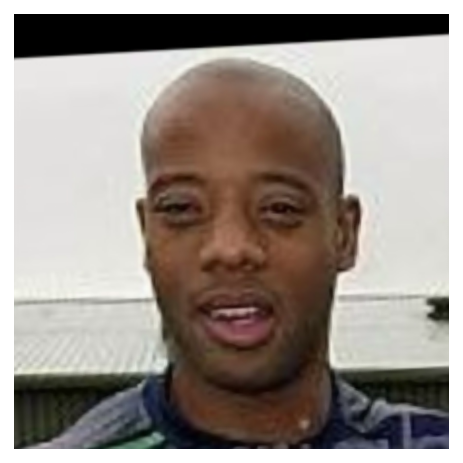

In [93]:
indian_img_path = pd.read_pickle("results/arcface/African/result_dict1.pickle")["data"][437:438].original_image.values[0]
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = increase_espcn_resolution)
plt.imshow(indian_img)
plt.axis('off');

In [94]:
indian_img.size

2408448

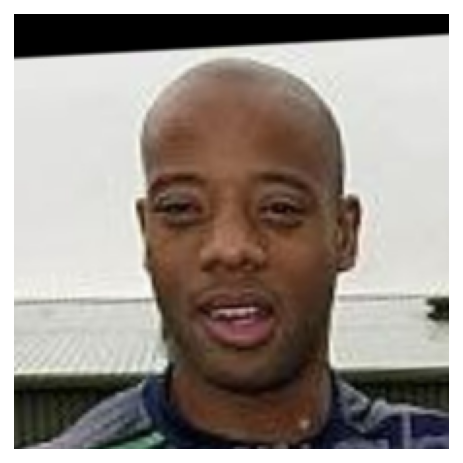

In [95]:
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = None)
plt.imshow(indian_img)
plt.axis('off');

In [96]:
indian_img.size

150528

# Evaluation

## Performance comparison

Due to the balanced target labels (50% pairs and 50% non-pairs) we chose to use Accuracz and AUROC as evaluation metrics.

### Facenet512

In [12]:
facenet_model = "facenet_espcn_resolution"

In [13]:
facenet_summary = get_metric_comparision(facenet_model, roc_auc_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Caucasian,0.869015,0.867730,0.870301
0,Indian,0.862816,0.861434,0.864197
0,African,0.846310,0.844849,0.847772
0,Asian,0.825364,0.823807,0.826922


In [14]:
facenet_summary = get_metric_comparision(facenet_model, accuracy_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.801620,0.800126,0.803114
0,Asian,0.780163,0.778670,0.781656
0,African,0.777507,0.775989,0.779024
0,Caucasian,0.743007,0.741431,0.744583


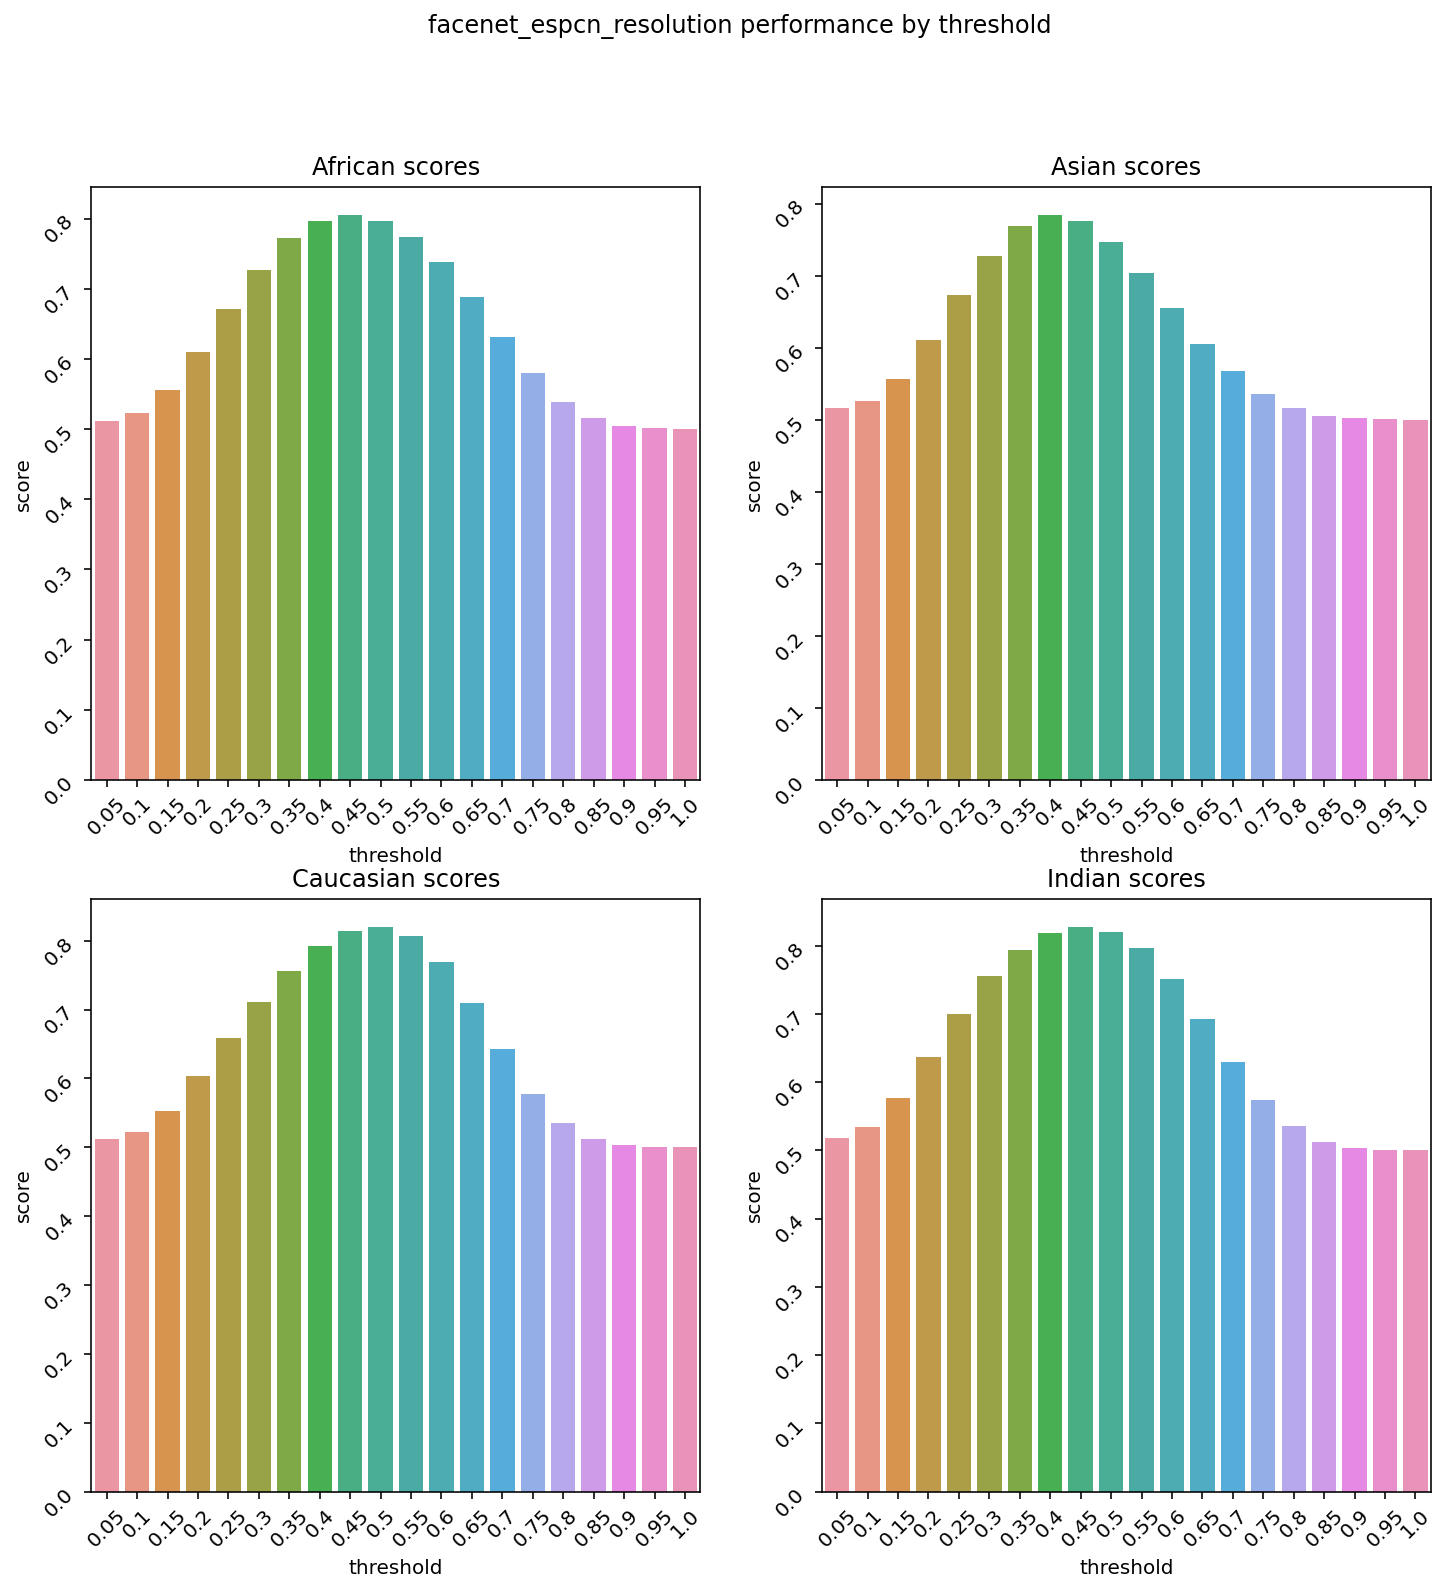

In [15]:
plot_performance_per_threshold(facenet_model)

**Result**:
* Significant performance drop from Indian to Asian (appx. 10% AUROC and accuracy)
* Interestingly Indian lower CI is higher than higher CI of Caucasians
* CI of Asians is also wider
* Best performing thresholds differ. Especially Asian which tells us that one threshold might not make sense

### VGG-Face

In [19]:
vgg_face_model = "vgg_face_espcn_resolution"


In [20]:
vgg_summary = get_metric_comparision(vgg_face_model, roc_auc_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.801043,0.799486,0.802600
0,Caucasian,0.772497,0.770693,0.774301
0,African,0.750589,0.748849,0.752328
0,Asian,0.733672,0.731870,0.735473


In [21]:
vgg_summary = get_metric_comparision(vgg_face_model, accuracy_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.713540,0.711897,0.715183
0,Caucasian,0.710977,0.709298,0.712655
0,African,0.671187,0.669581,0.672792
0,Asian,0.638767,0.637130,0.640403


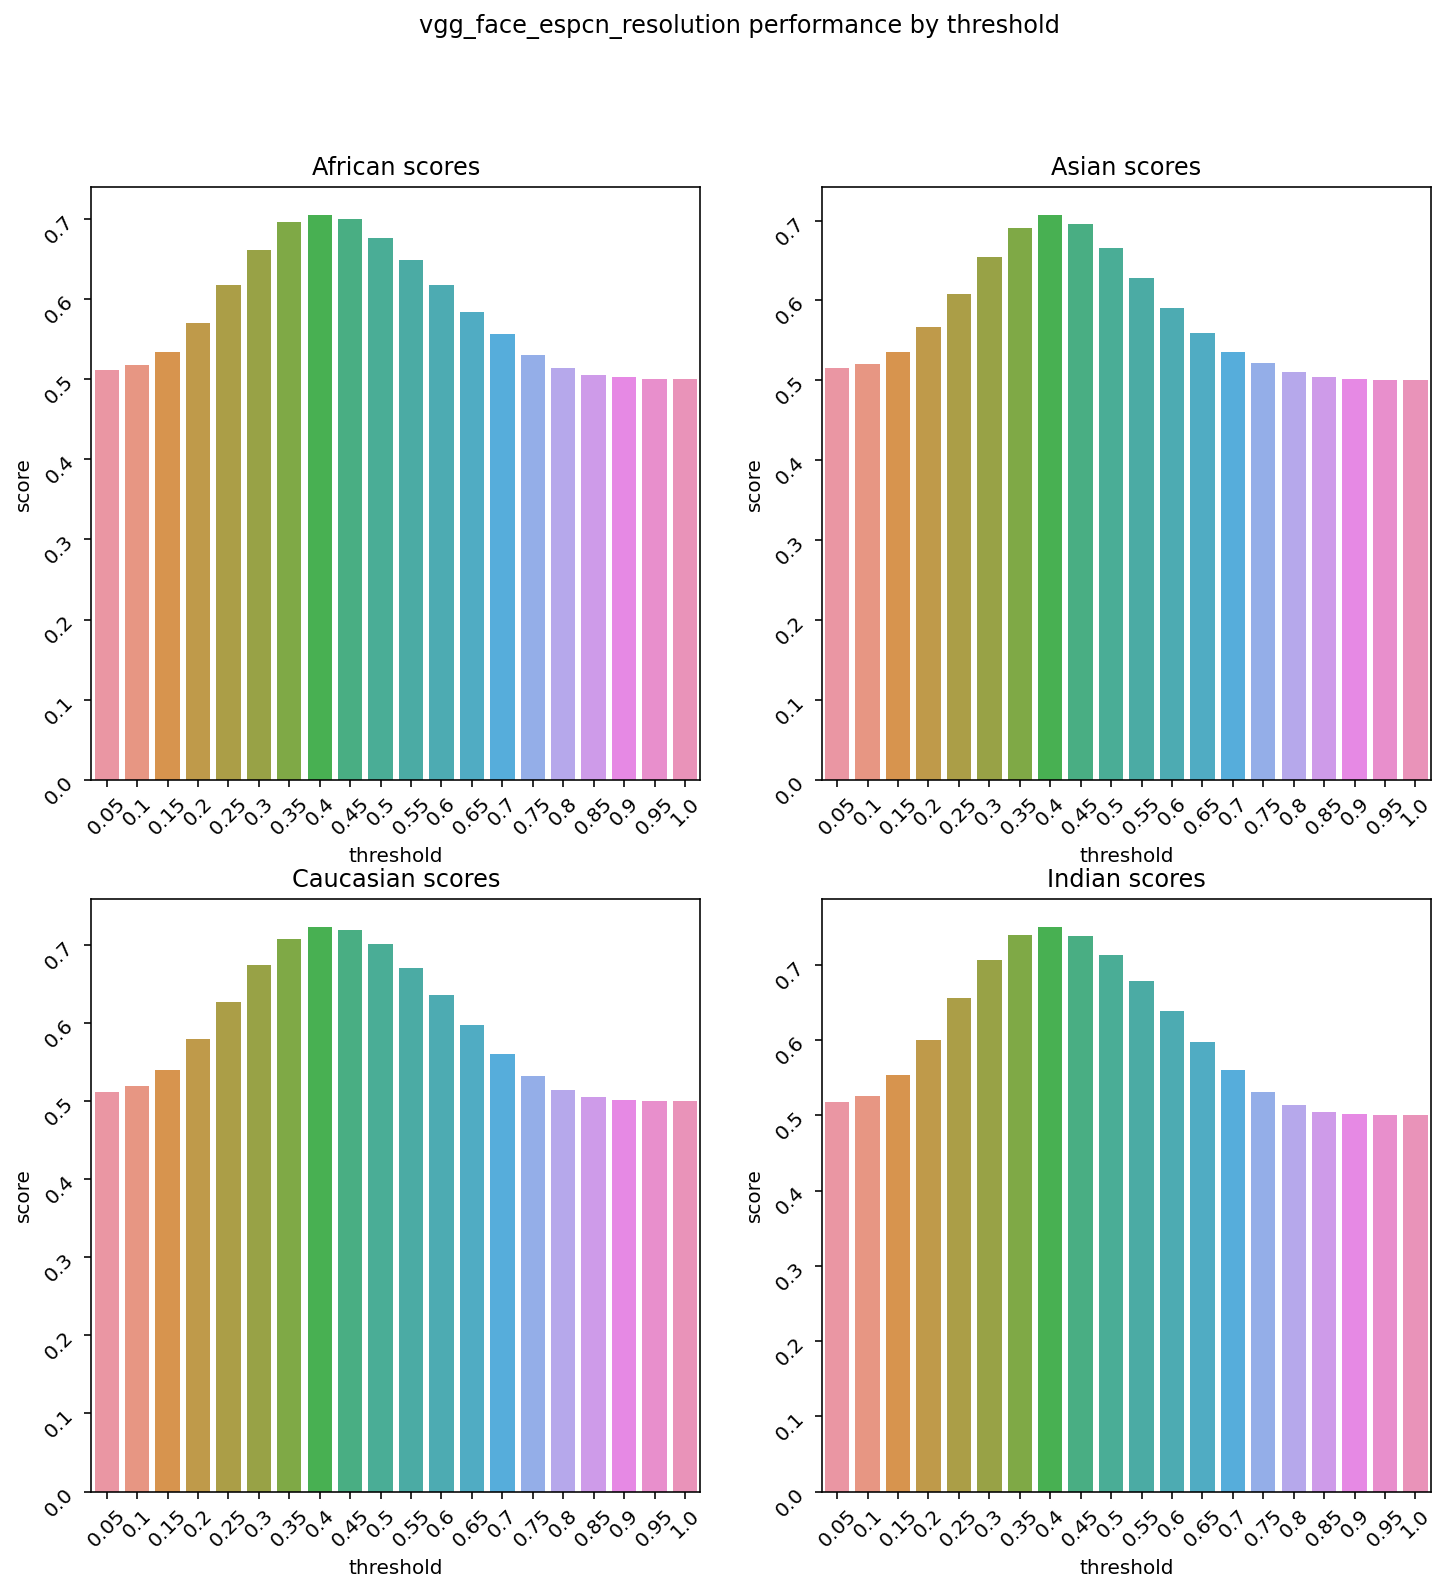

In [22]:
plot_performance_per_threshold(vgg_face_model)

**Result**:
* Overall performance is worse than with FaceNet512
* Mean performance is though only 6% difference between highest and lowest, indicating more fairness
* Varying performance for Asians again
* Partly overlapping CIs
* Thresholds are more fair which is reflected in the fair performance

### ArcFace

In [23]:
arcface_model = "arcface_espcn_resolution"

In [24]:
arcface_summary = get_metric_comparision(arcface_model, roc_auc_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.734752,0.732806,0.736699
0,Caucasian,0.727134,0.725293,0.728974
0,African,0.703548,0.701624,0.705473
0,Asian,0.681877,0.679886,0.683869


In [25]:
arcface_summary = get_metric_comparision(arcface_model, accuracy_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Caucasian,0.615730,0.614039,0.617421
0,Indian,0.603270,0.601499,0.605041
0,African,0.594640,0.593053,0.596227
0,Asian,0.576737,0.574961,0.578513


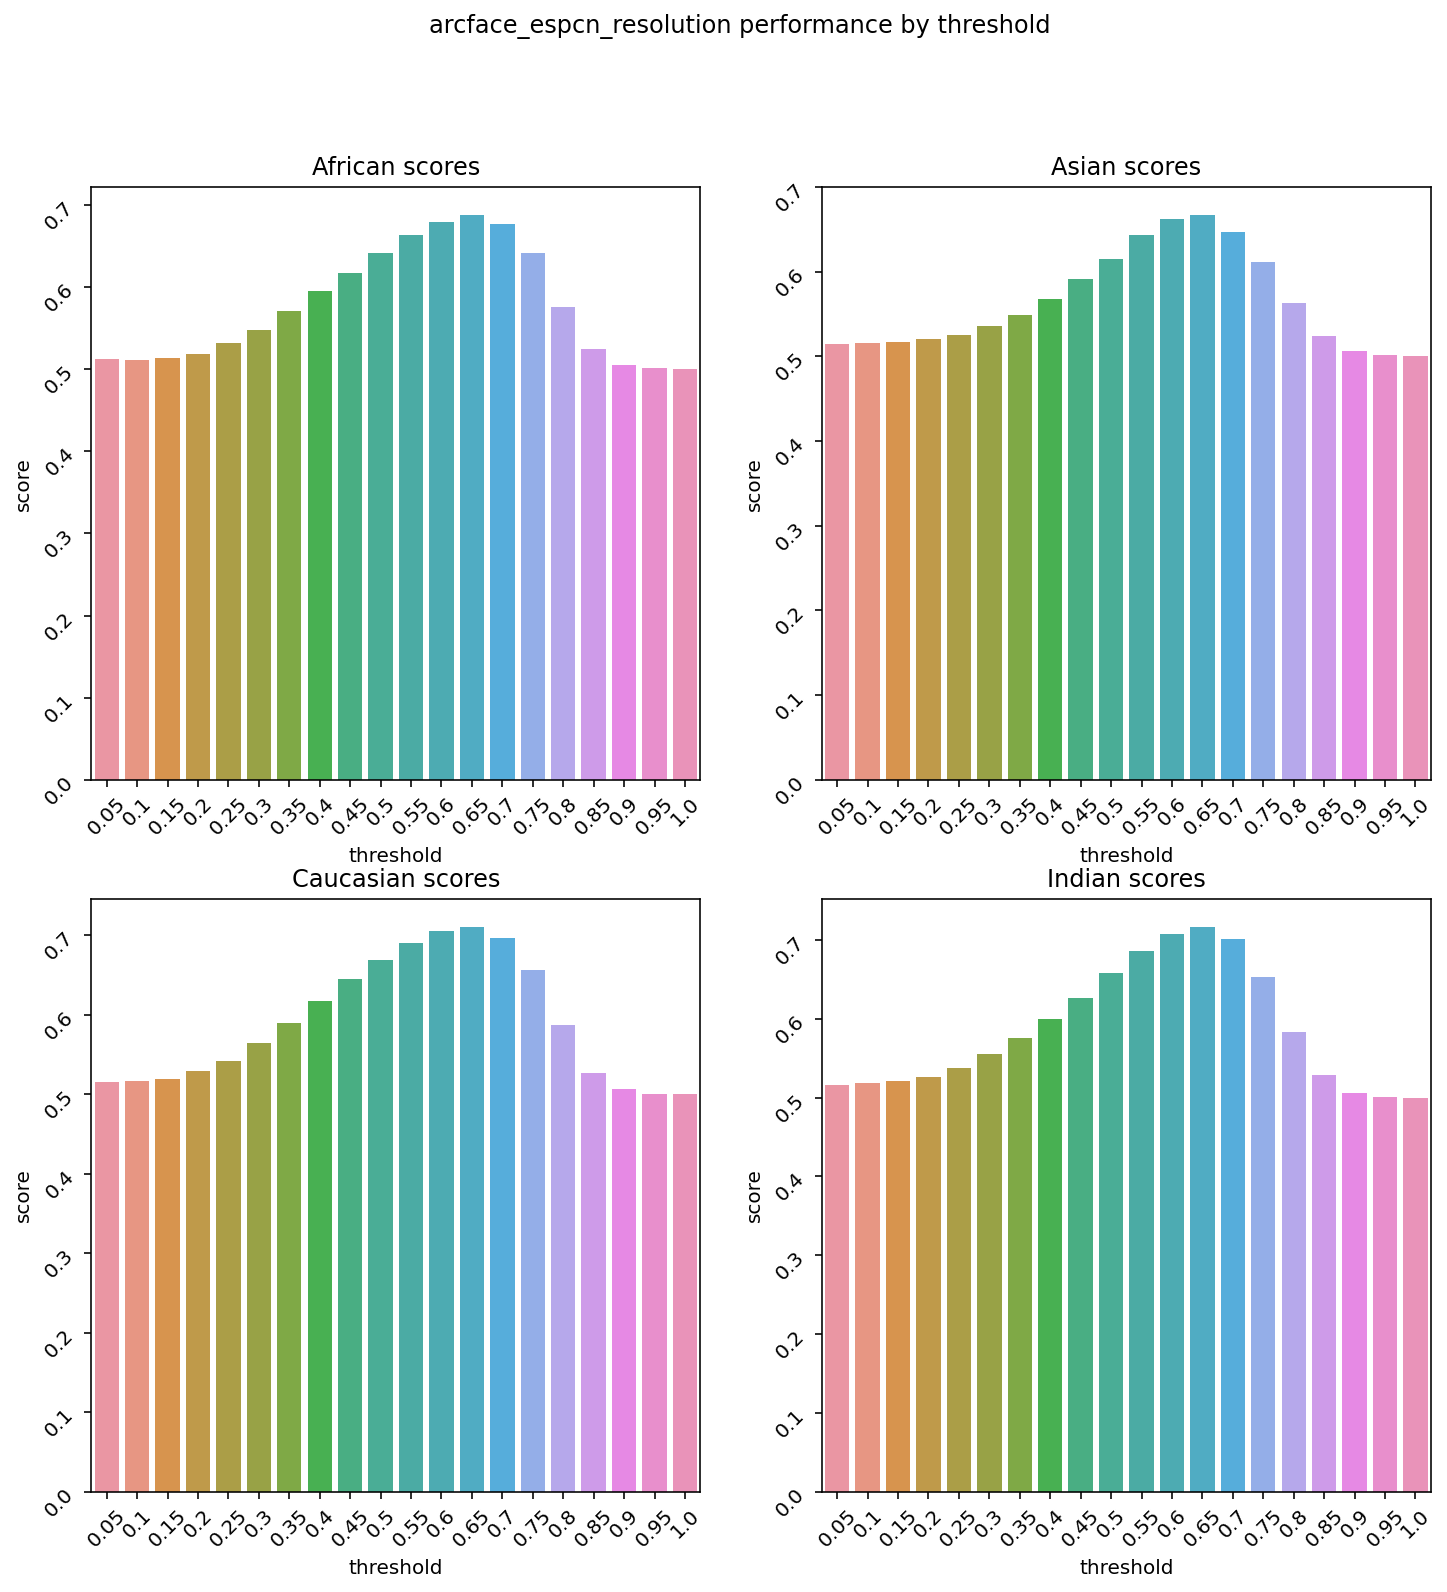

In [26]:
plot_performance_per_threshold(arcface_model)

**Result**:
* Worst overall performance
* Only 5% decrease between best and worst which seems to be fairer
* Asians again wide CI compared to e.g. Caucasian
* Best thresholds is shifted to the right but rather similar

## Distance distribution

This is the distribution of the predicted distance between the pairs. In a first plot they will be generally visualised and then paised on pairs vs. non-pairs.
An ideal model would predict two peaking curves on the outer ends of the plot indicating good discrimination.

### FaceNet512

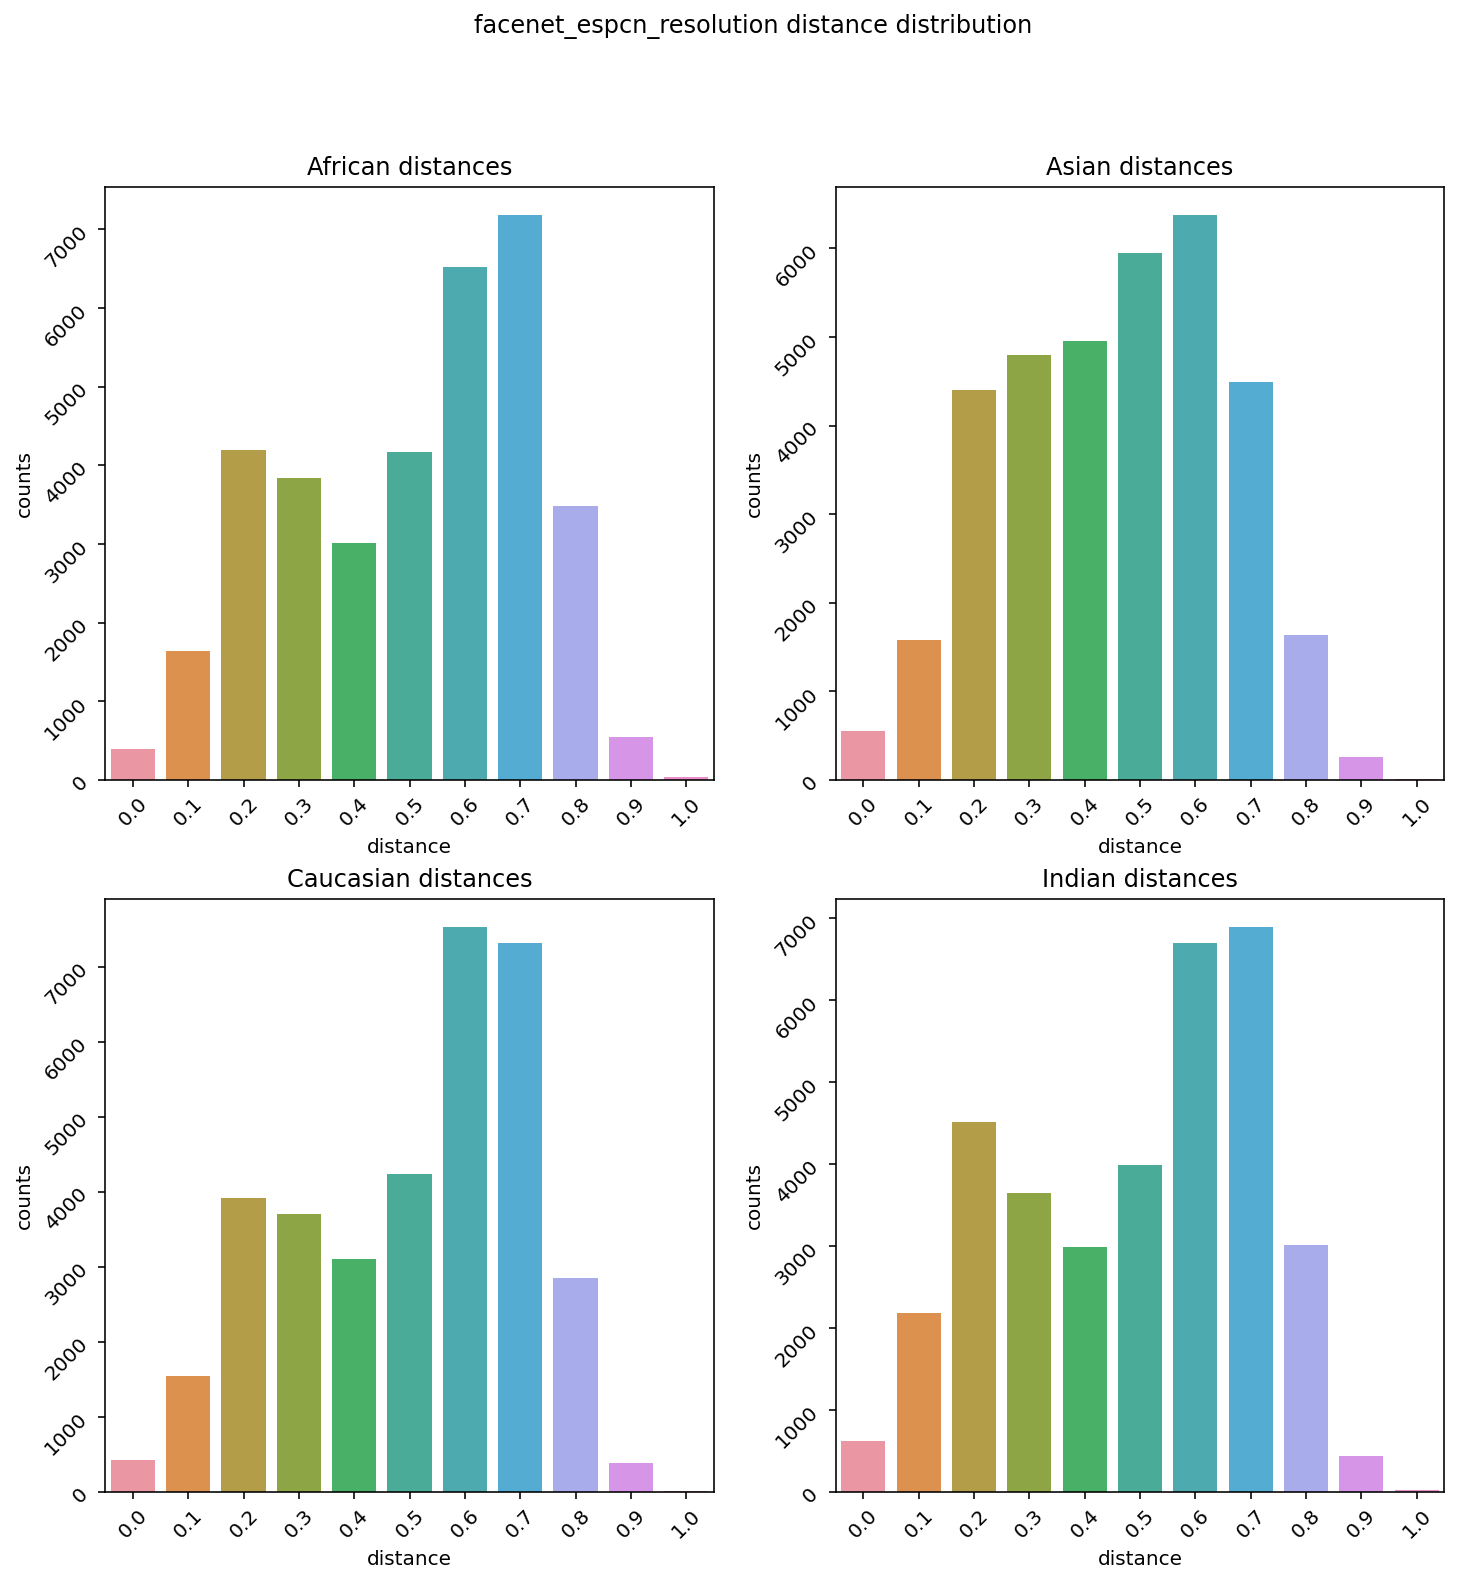

In [27]:
plot_score_distribution(facenet_model)

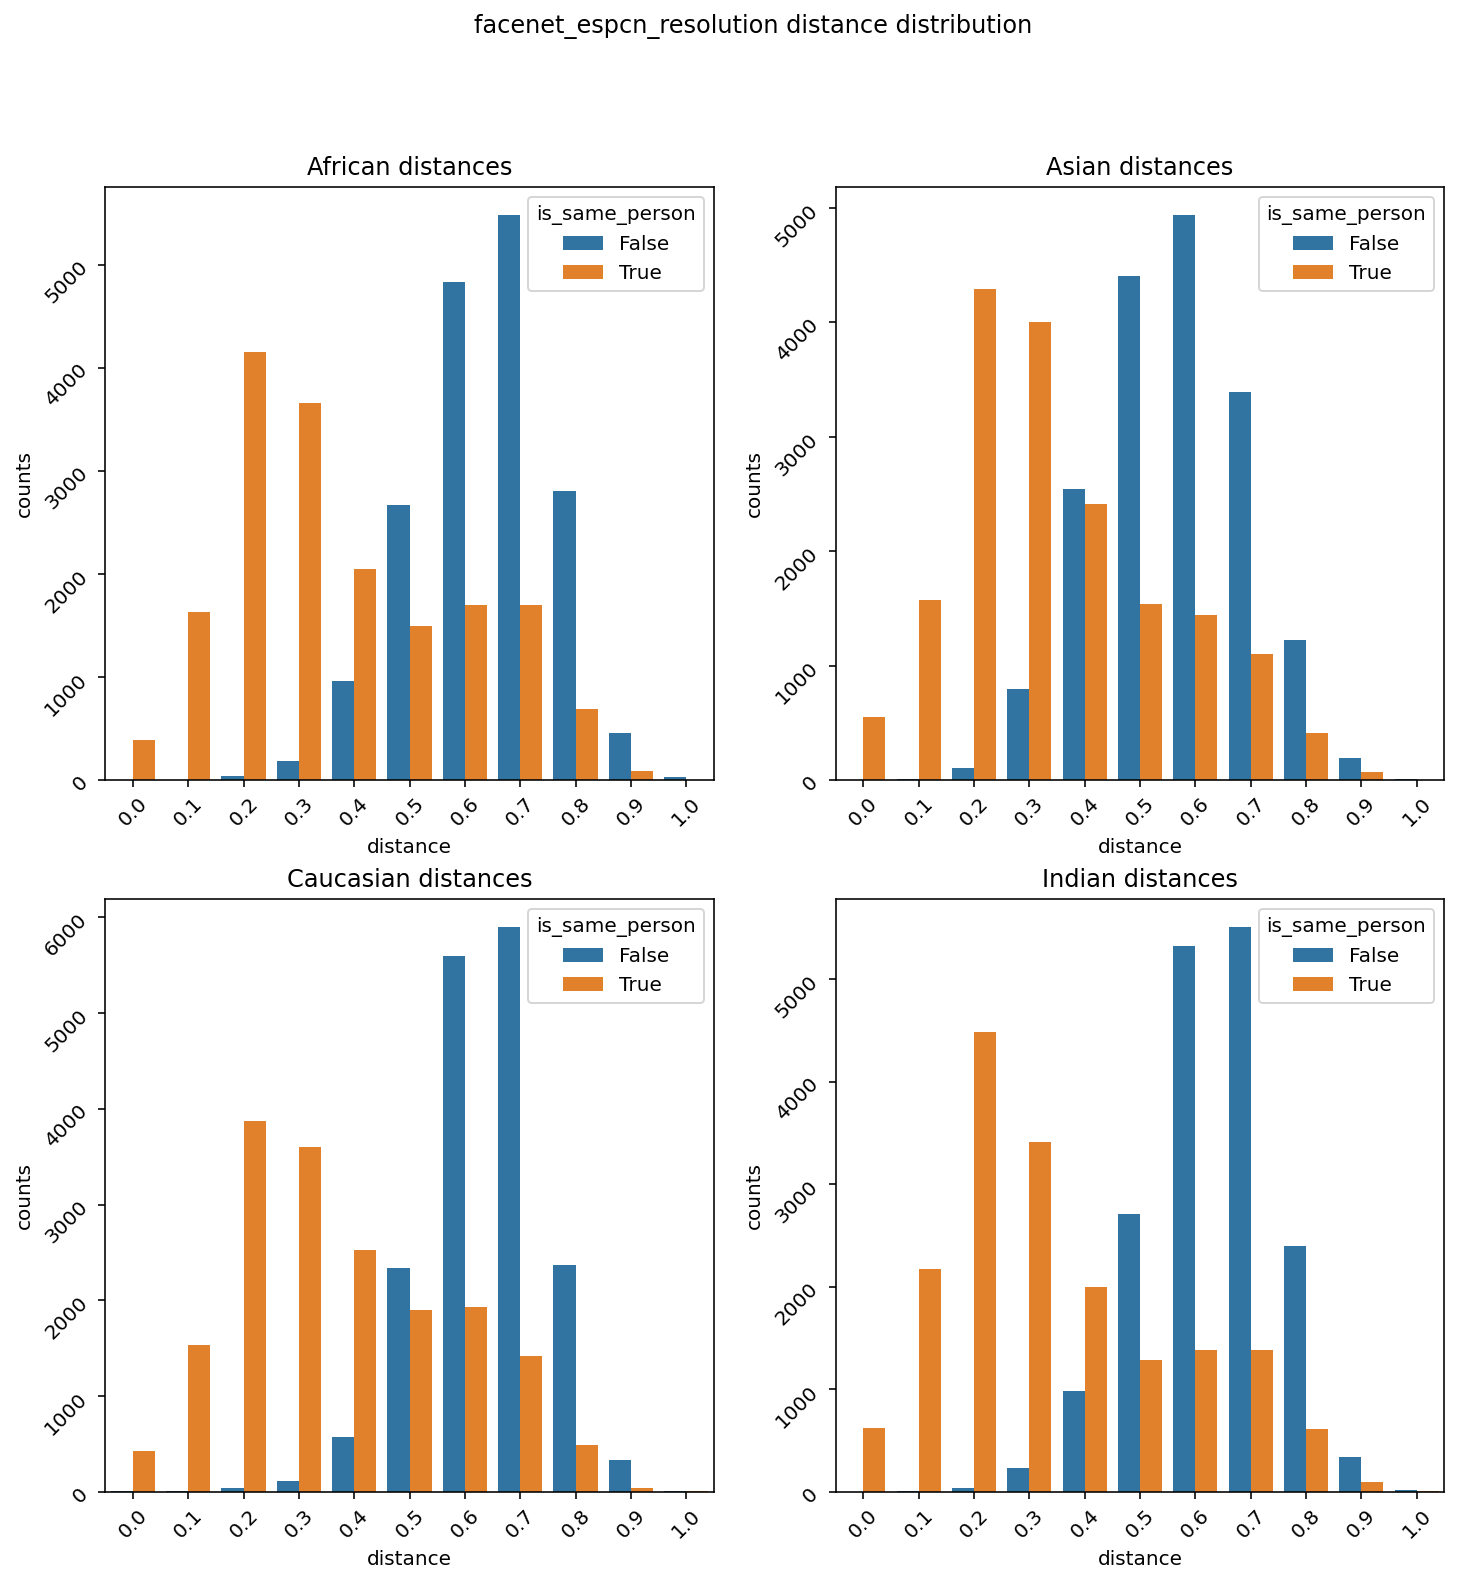

In [28]:
plot_score_distribution(facenet_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [29]:
print("Asian difference in mean:",calculate_distribution_difference(facenet_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(facenet_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(facenet_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(facenet_model,"Indian"))

Asian difference in mean: -0.3066982745842012
African difference in mean: -0.37992580824294364
Caucasian difference in mean: -0.41315109509777326
Indian difference in mean: -0.41455315650640845


**Results**:
* Only the Asian model does not show two spiking parts. This means the distinction is done very badly. For the three other spikes are at least visible.
* All models have heavy overlaps which means there is always a trade off when choosing a threshold.
* Only the asian threshold is shifted to the left.

### VGG-Face


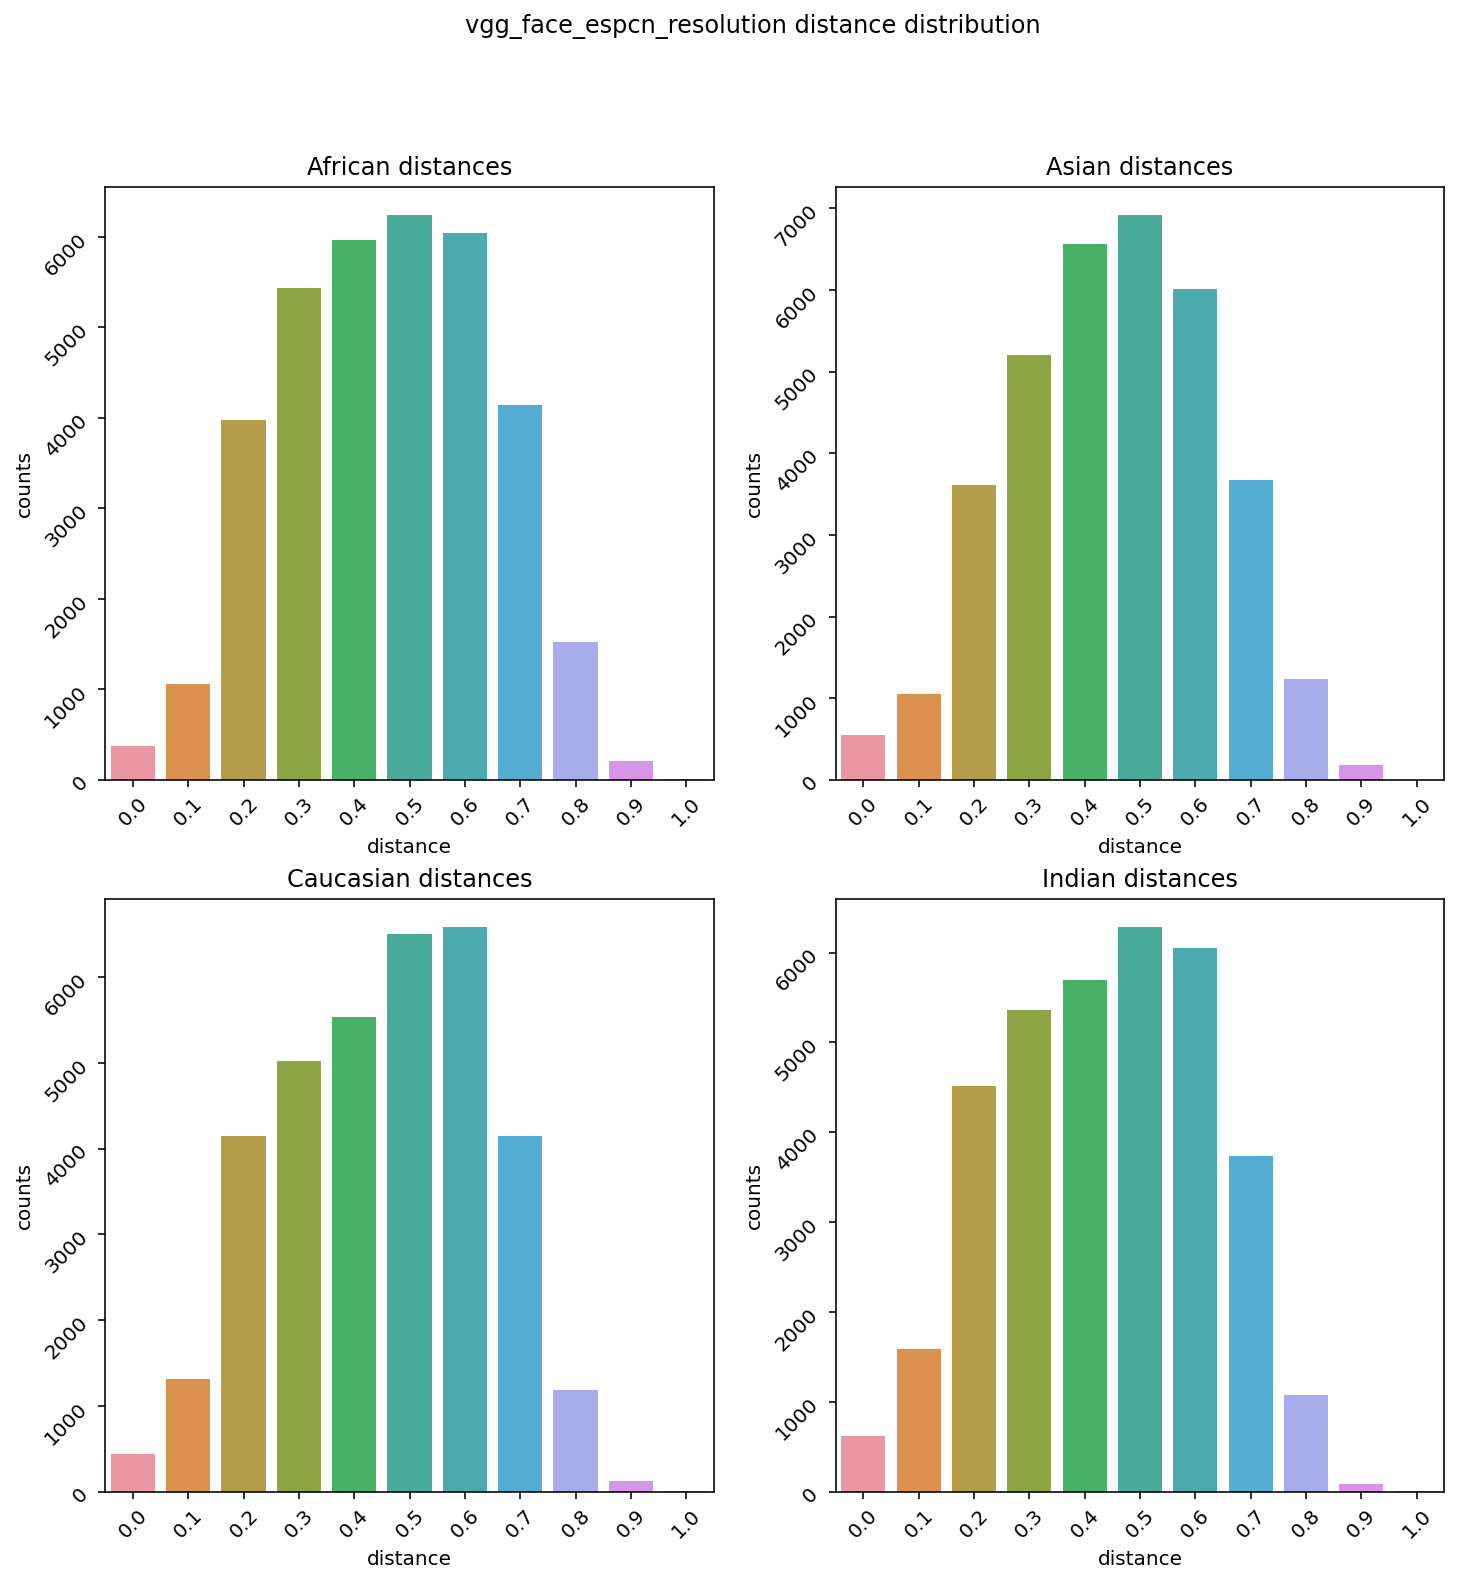

In [30]:
plot_score_distribution(vgg_face_model)

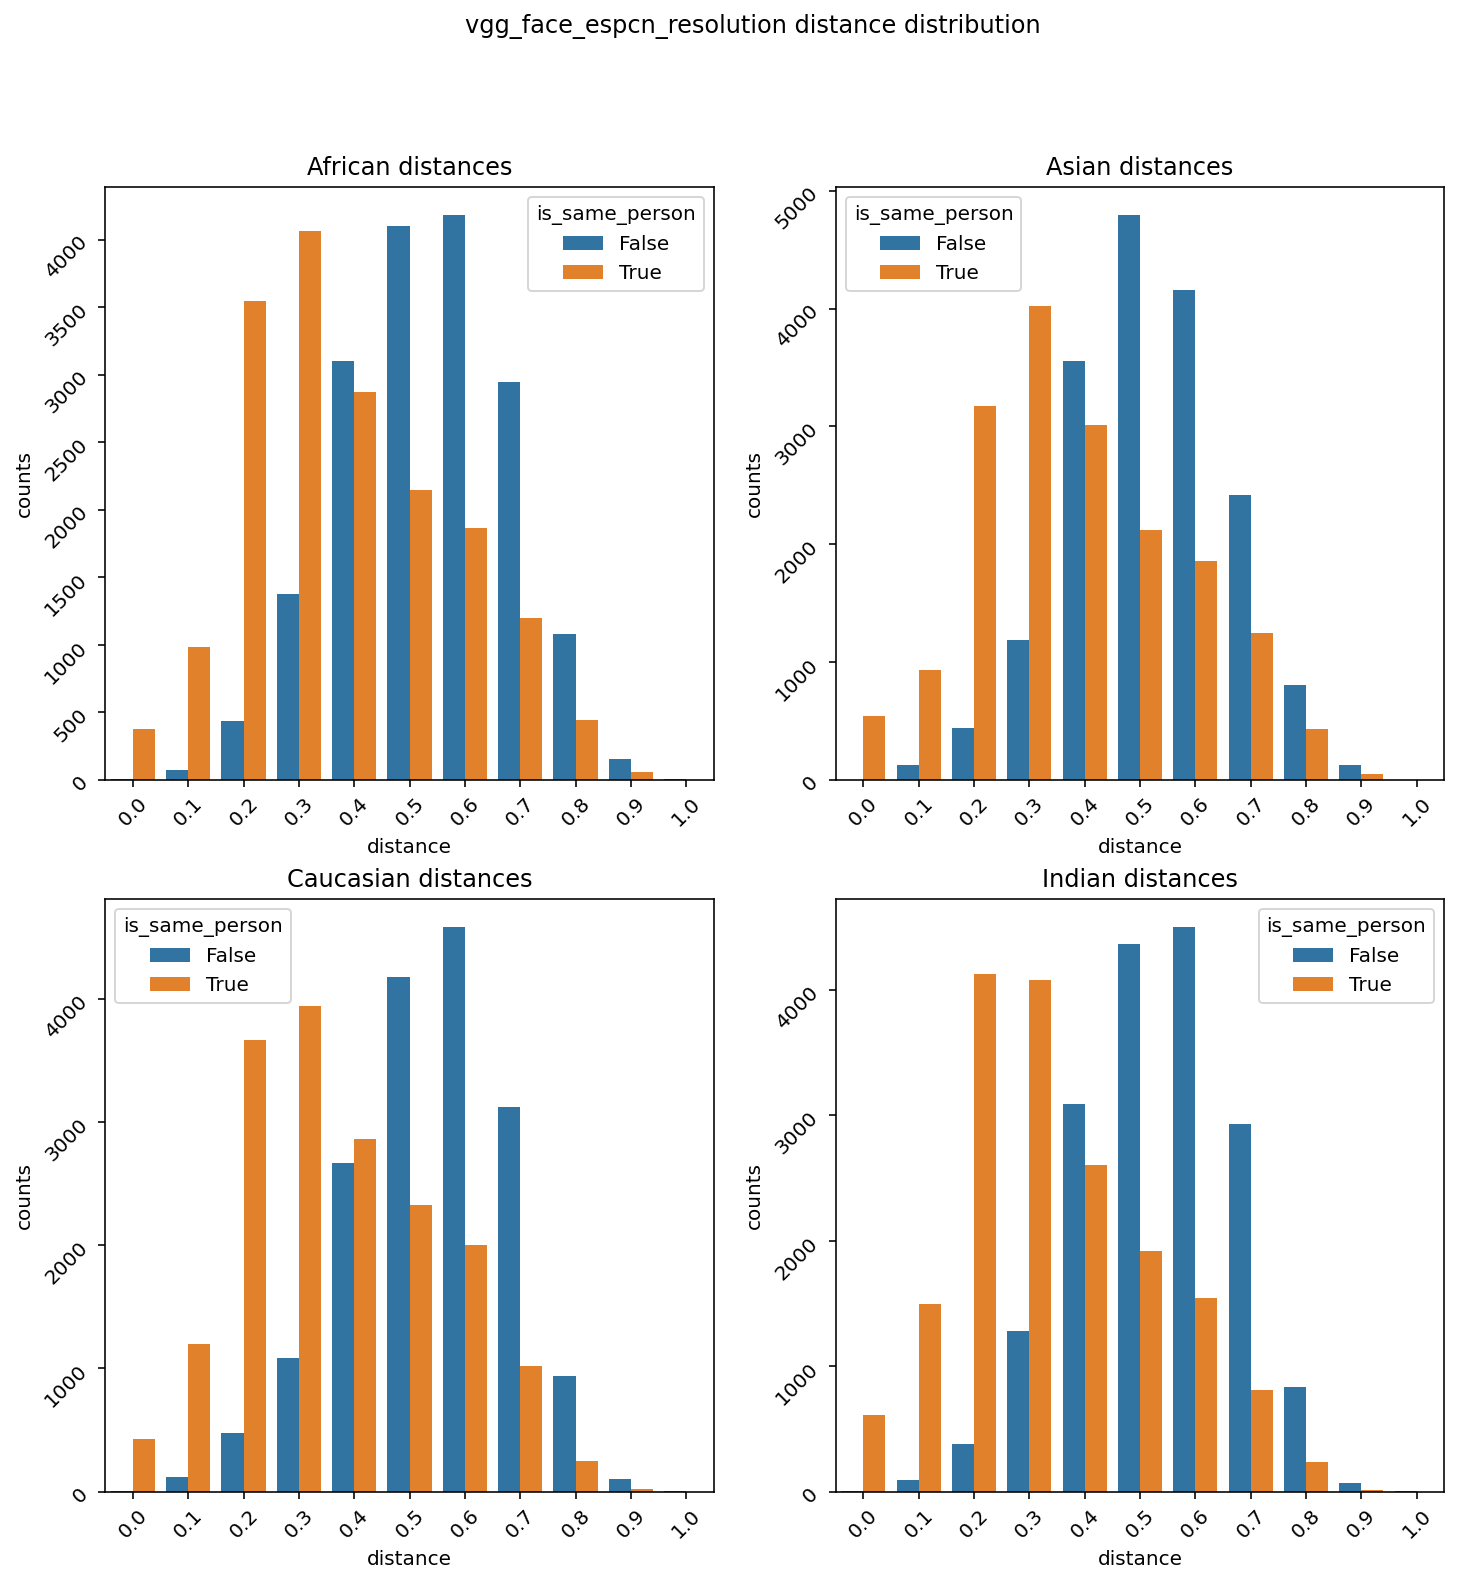

In [31]:
plot_score_distribution(vgg_face_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [32]:
print("Asian difference in mean:",calculate_distribution_difference(vgg_face_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(vgg_face_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(vgg_face_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(vgg_face_model,"Indian"))

Asian difference in mean: -0.1421553657799799
African difference in mean: -0.16223285098948803
Caucasian difference in mean: -0.19454101895094128
Indian difference in mean: -0.20481852253932376


**Results**:
* No spikes in any ethnic group indicating bad discrimination.
* Even heavier overlaps = worse performance

### ArcFace

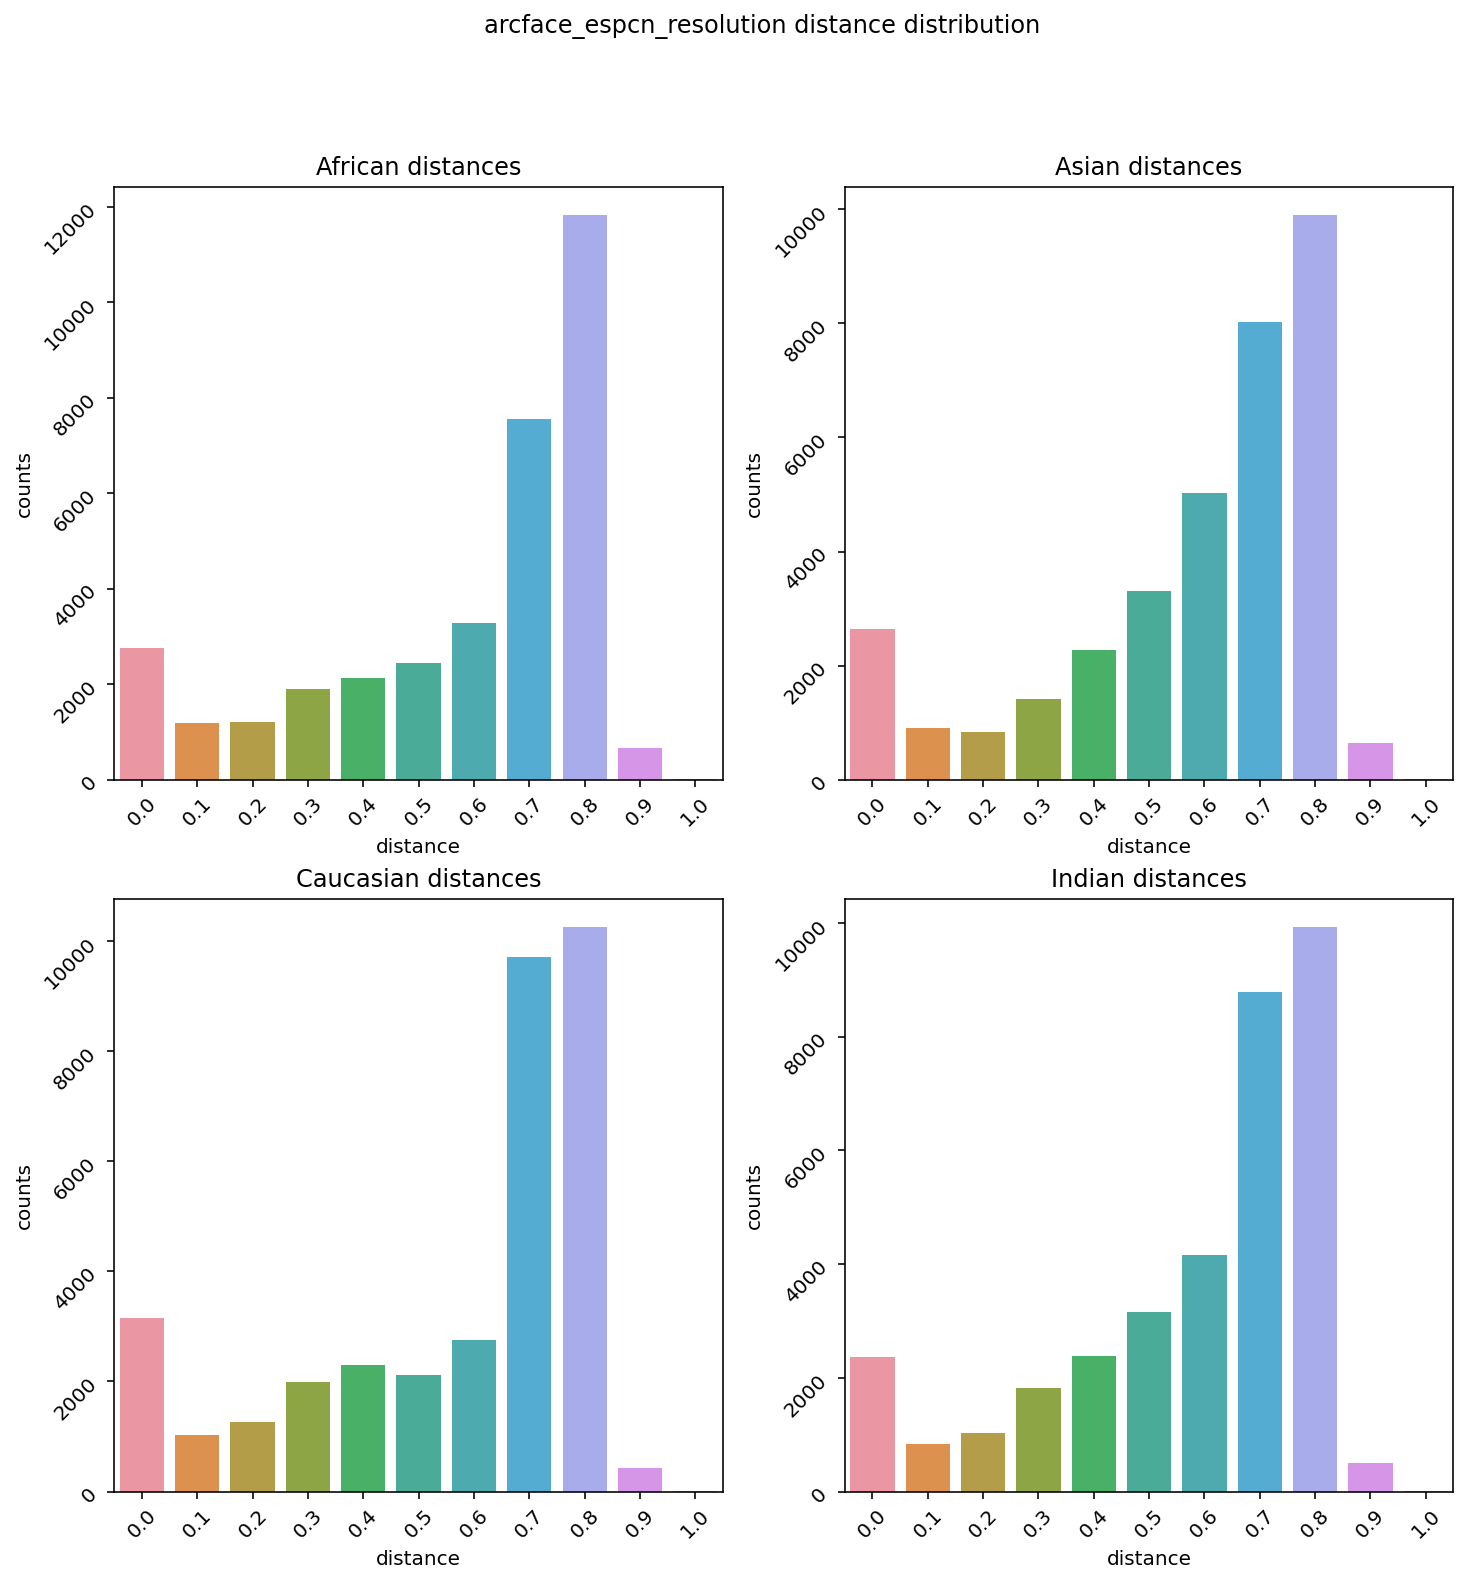

In [33]:
plot_score_distribution(arcface_model)

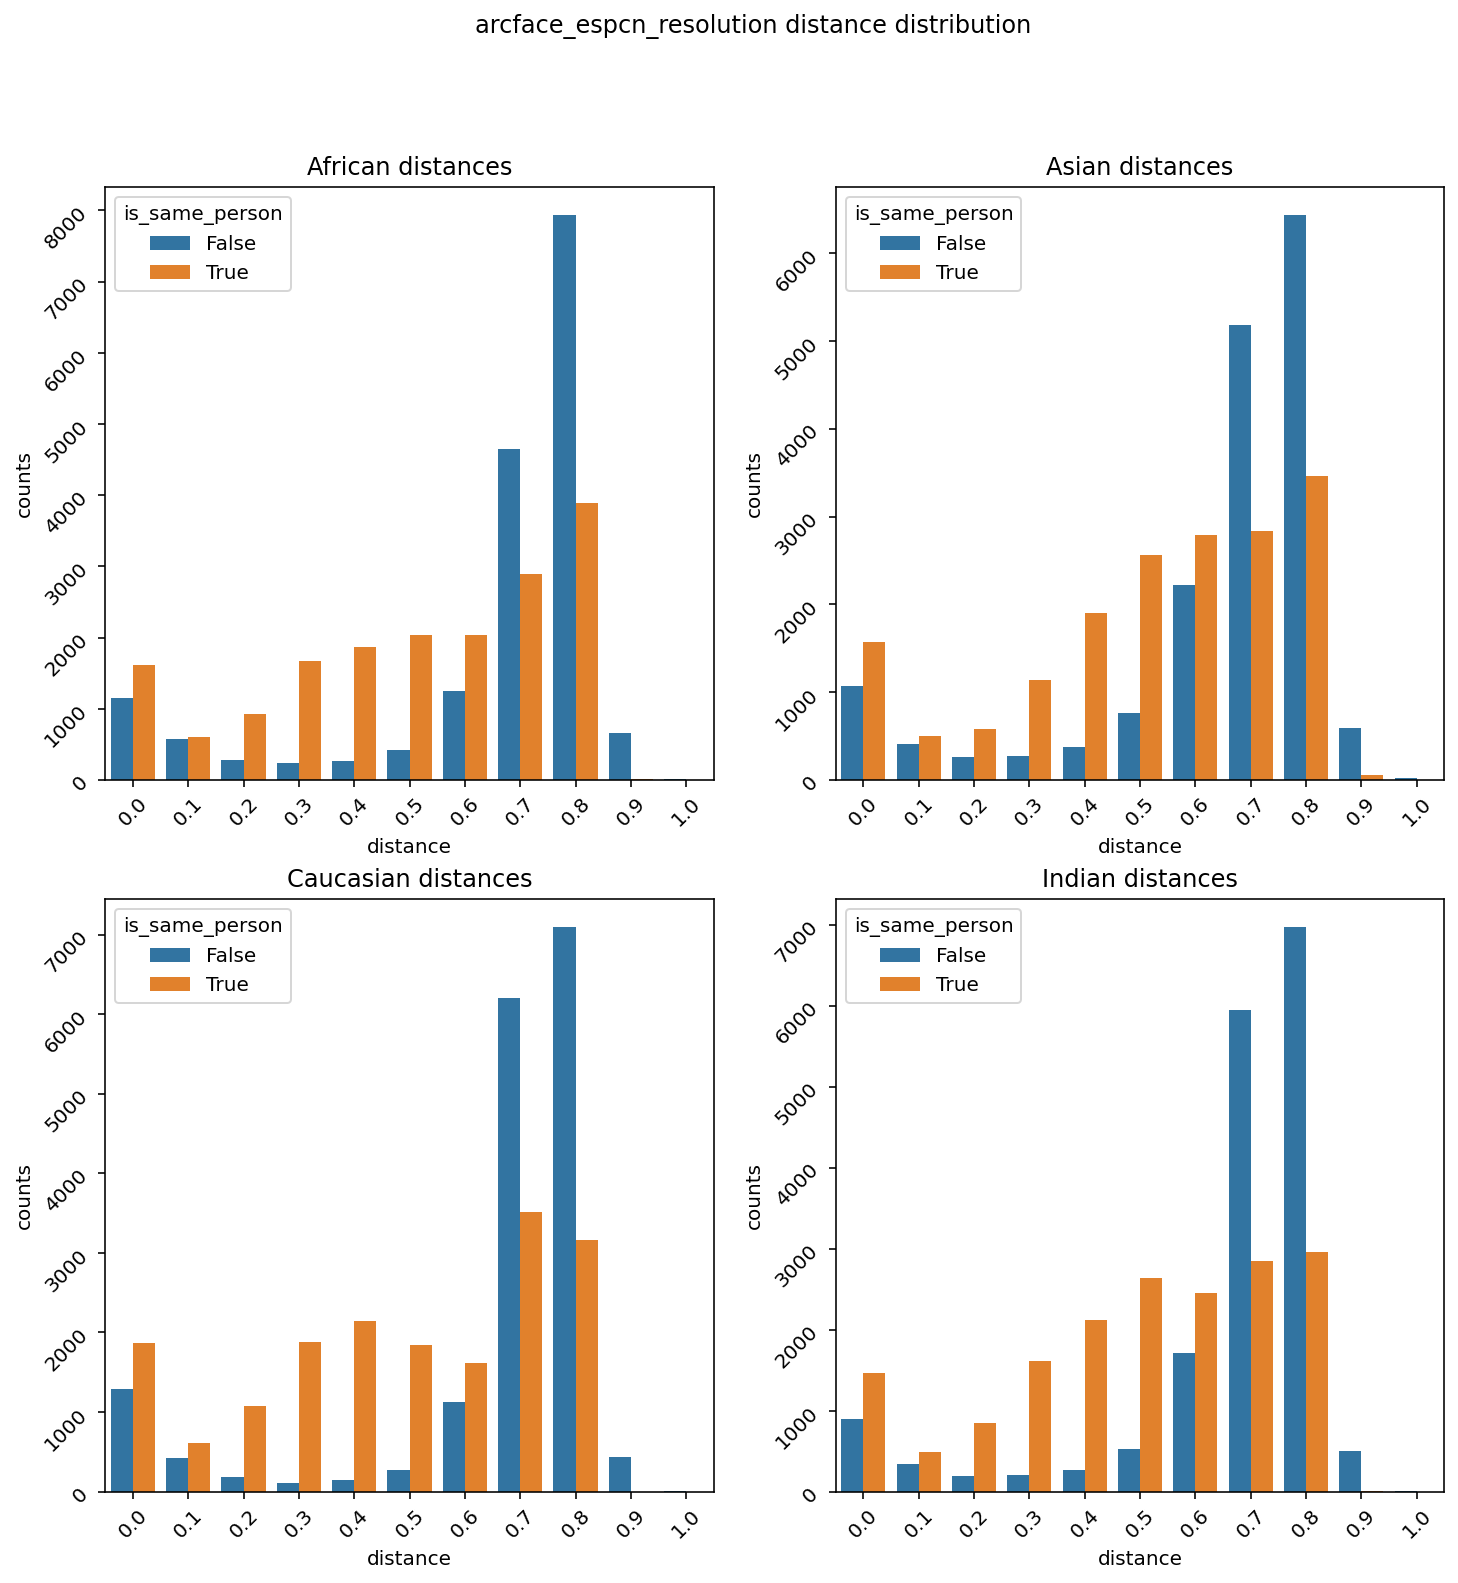

In [34]:
plot_score_distribution(arcface_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [35]:
print("Asian difference in mean:",calculate_distribution_difference(arcface_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(arcface_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(arcface_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(arcface_model,"Indian"))

Asian difference in mean: -0.15472242366484246
African difference in mean: -0.1896343952872448
Caucasian difference in mean: -0.22456998958851626
Indian difference in mean: -0.2111687854094635


**Results**:
* For all groups there are one or two spikes around 0.7 & 0.8
* Also the amount of non-pairs with 0 distance is significantly higher
* The distance of pairs is partly uniformly distributed (see African distances)
* Almost no discrimination power
* Generally big shift to the higher distances, might be due to geometric approach of ArcFace

## Paired significance tests

Usually a paired t-test would be the desired solution. However the normal distribution of the target variable is not fulfilled which is why we will go with a Wilcoxon-Signed-Rank-Test which is slightly less effective but has less assumptions.

The goal is to investigate if there are significant differences in the mean of the ethnic groups produced by a model. An unbiased model would present similar results. The two-sided test has the null hypothesis that the median of the differences is zero against the alternative that it is different from zero.

For independent sample we will use the Wilcoxon-RankSum-Test (NUll hypothesis = the observations come from the same population).

### General

The first step is to generate all possible combinations of comparisons

In [36]:
def perform_significance_test(model1, model2, ethnic, test_type = st.wilcoxon):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for j in range(1,6):
        with open(f'results/{model1}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data1 = data1.append(data_temp)
        
        with open(f'results/{model2}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data2 = data2.append(data_temp)        

    return test_type(data1.distance, data2.distance)


In [37]:
ethnic_groups = ["Caucasian", "Asian", "African", "Indian"]

### FaceNet512

In [38]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance:",perform_significance_test("facenet", facenet_model, ethnic)[1])

Wilcoxon test on Caucasian performance: 9.786408582379122e-47
Wilcoxon test on Asian performance: 2.746917739348663e-177
Wilcoxon test on African performance: 2.4131726199832735e-160
Wilcoxon test on Indian performance: 2.7897957988977693e-157


**Results**:
* Testing all combinations lets us reject all null hypothesises

### VGG-Face

In [39]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("vgg_face", vgg_face_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  1.4610096751233644e-18
Wilcoxon test on Asian performance:  0.0
Wilcoxon test on African performance:  9.298047862034418e-126
Wilcoxon test on Indian performance:  1.3414867372715129e-151


**Results**:
* Testing all combinations lets us reject all null hypothesises

### ArcFace

In [40]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("arcface", arcface_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  4.347580221407719e-08
Wilcoxon test on Asian performance:  0.005723511943824896
Wilcoxon test on African performance:  2.572073816020425e-08
Wilcoxon test on Indian performance:  8.734538764781406e-19


**Results**:
* Testing all combinations lets us reject all null hypothesises

## Image description with Lime

Differnent models identify different areas in an image as important. Here we want to compare which areas are important to which model.

Ideally the ethic groups should be described similarly.

### General

In [41]:
asian_img_path ='data/race_per_7000/Asian/m.03cfpv1/000050_00@en.jpg'
african_img_path = 'data/race_per_7000/African/m.03v416/32-FaceId-0_align.jpg'
caucasian_img_path = 'data/race_per_7000/Caucasian/m.0356k8/26-FaceId-0_align.jpg'
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'

### FaceNet512

In [64]:
def load_image(shape,path,preprocessing = None):
    if preprocessing is not None:
        img = Image.open(path)
        img = np.array(img)
        img = preprocessing(img)
        img = cv2.resize(img, dsize=shape, interpolation=cv2.INTER_CUBIC) 
    else:
        img = Image.open(path).resize(shape)
        img = np.array(img)
    return img

In [65]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(160,160), preprocessing = increase_espcn_resolution)
african_img = load_image(path=african_img_path,shape=(160,160), preprocessing = increase_espcn_resolution)
caucasian_img = load_image(path=caucasian_img_path,shape=(160,160), preprocessing = increase_espcn_resolution)
indian_img = load_image(path=indian_img_path,shape=(160,160), preprocessing = increase_espcn_resolution)

In [66]:
facenet512 = DeepFace.build_model("Facenet512")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 21.41478962859334
Prediction_local [12.63274293]
Right: 12.3686075
Intercept 23.859802508952825
Prediction_local [14.29747923]
Right: 14.014129


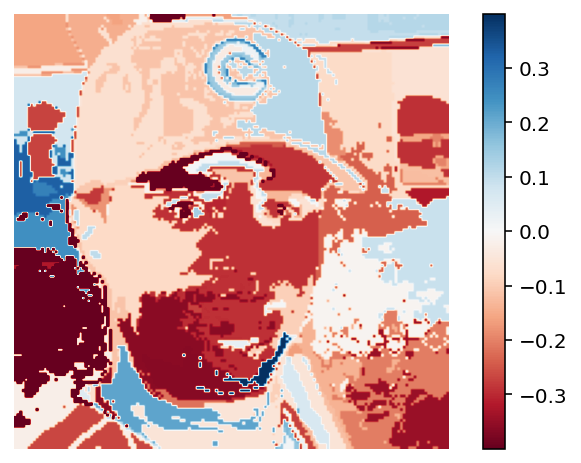

In [67]:
plot_face_heatmap(facenet512, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 33.63655914948594
Prediction_local [20.44161398]
Right: 20.000195
Intercept 24.46449451665842
Prediction_local [20.24498059]
Right: 20.103401


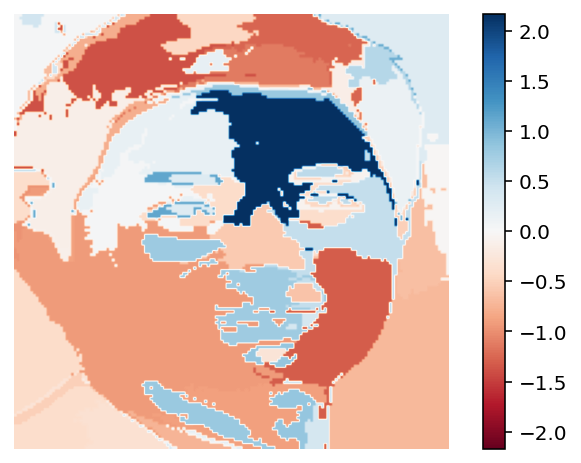

In [68]:
plot_face_heatmap(facenet512, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 22.520490835665218
Prediction_local [10.63199562]
Right: 10.39489
Intercept 15.846322198467298
Prediction_local [10.57580749]
Right: 10.631647


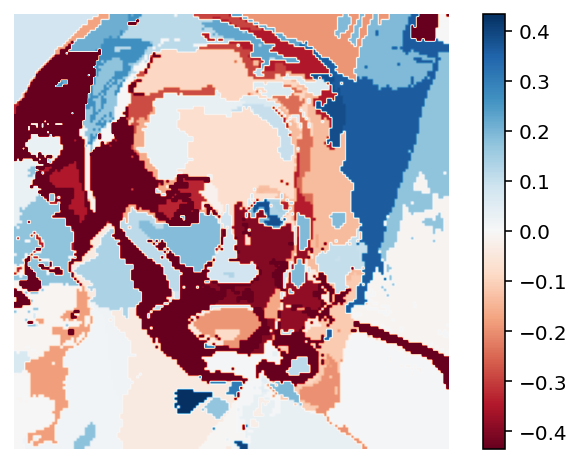

In [69]:
plot_face_heatmap(facenet512, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 32.40244442063343
Prediction_local [16.44867922]
Right: 16.227398
Intercept 24.22072258653769
Prediction_local [16.43962139]
Right: 16.38195


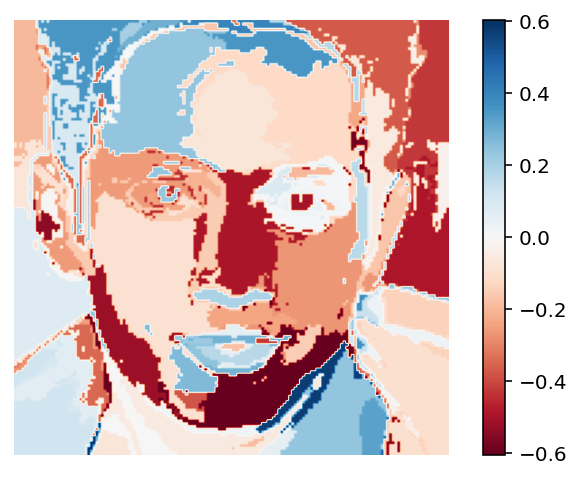

In [70]:
plot_face_heatmap(facenet512, indian_img)

### VGG-Face

In [71]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(224,224), preprocessing = increase_espcn_resolution)
african_img = load_image(path=african_img_path,shape=(224,224), preprocessing = increase_espcn_resolution)
caucasian_img = load_image(path=caucasian_img_path,shape=(224,224), preprocessing = increase_espcn_resolution)
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = increase_espcn_resolution)

In [72]:
vgg_face = DeepFace.build_model("VGG-Face")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.5413467969728076
Prediction_local [10.40941774]
Right: 10.578065
Intercept -3.3123464606209714
Prediction_local [11.89937852]
Right: 12.124891


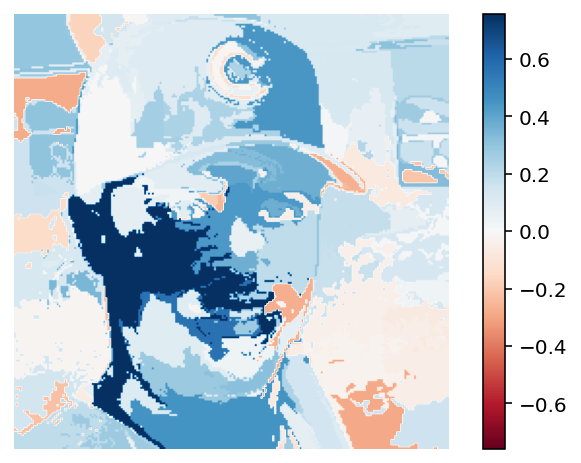

In [73]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.5036785505058798
Prediction_local [10.42169205]
Right: 10.578065
Intercept -3.7314455676514235
Prediction_local [11.88236212]
Right: 12.124891


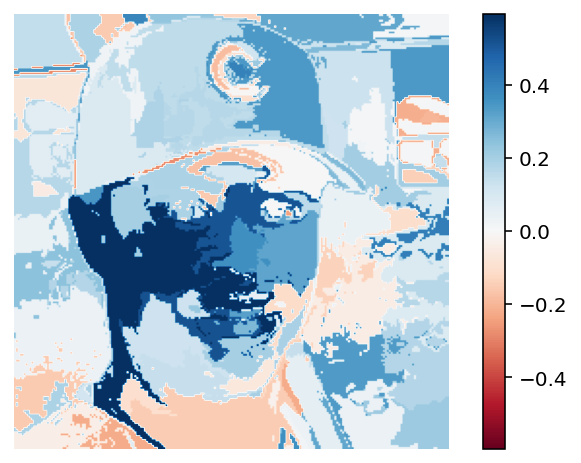

In [74]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -1.289178661623076
Prediction_local [14.8881115]
Right: 15.174727
Intercept -4.8115571537229425
Prediction_local [16.86307276]
Right: 17.253916


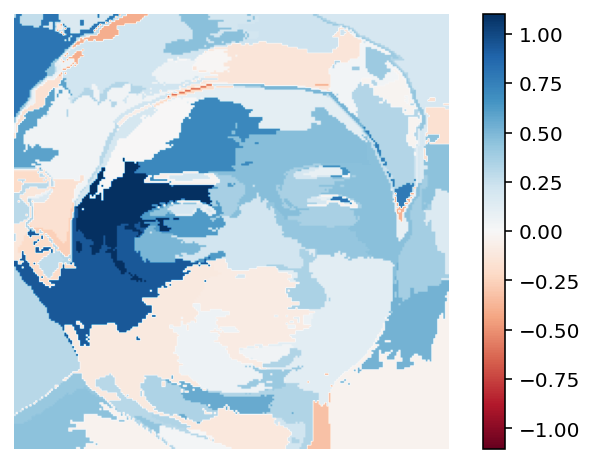

In [75]:
plot_face_heatmap(vgg_face, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -12.489251523087017
Prediction_local [20.345239]
Right: 21.010601
Intercept -15.833269580802458
Prediction_local [20.44316399]
Right: 21.186085


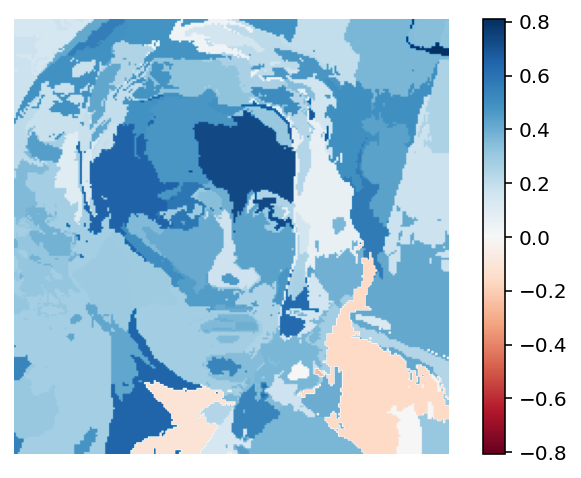

In [76]:
plot_face_heatmap(vgg_face, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -5.380133120794801
Prediction_local [10.98987555]
Right: 11.160767
Intercept -4.999344523911117
Prediction_local [11.90069186]
Right: 12.04598


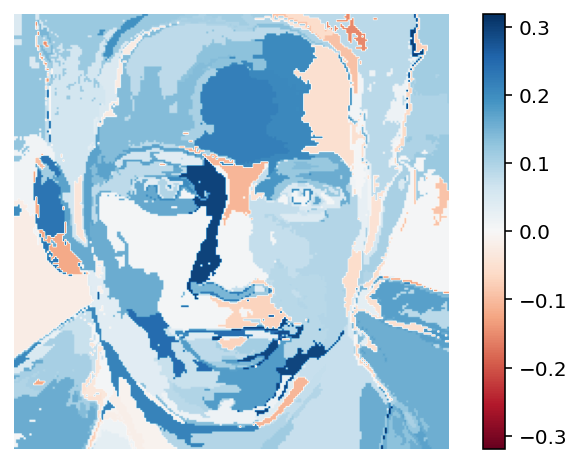

In [77]:
plot_face_heatmap(vgg_face, indian_img)

### ArcFace

In [79]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(112,112), preprocessing = increase_espcn_resolution)
african_img = load_image(path=african_img_path,shape=(112,112), preprocessing = increase_espcn_resolution)
caucasian_img = load_image(path=caucasian_img_path,shape=(112,112), preprocessing = increase_espcn_resolution)
indian_img = load_image(path=indian_img_path,shape=(112,112), preprocessing = increase_espcn_resolution)

In [80]:
arcface = DeepFace.build_model("ArcFace")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 300.1043019578677
Prediction_local [966.53586945]
Right: 988.6433
Intercept 472.5853183890832
Prediction_local [1191.78317974]
Right: 1219.0675


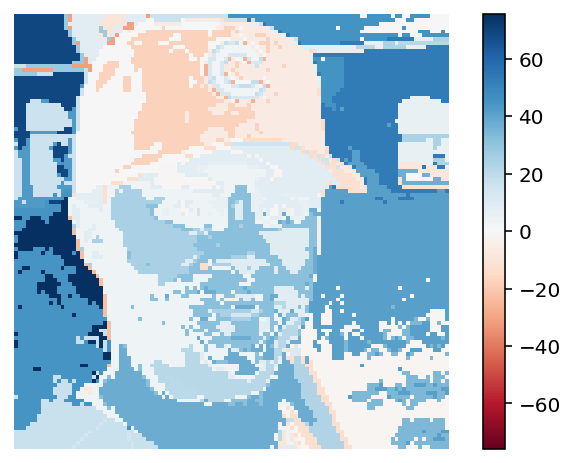

In [81]:
plot_face_heatmap(arcface, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 1215.4696924304942
Prediction_local [1515.82774383]
Right: 1517.9258
Intercept 631.6307942171284
Prediction_local [1770.38069333]
Right: 1821.2834


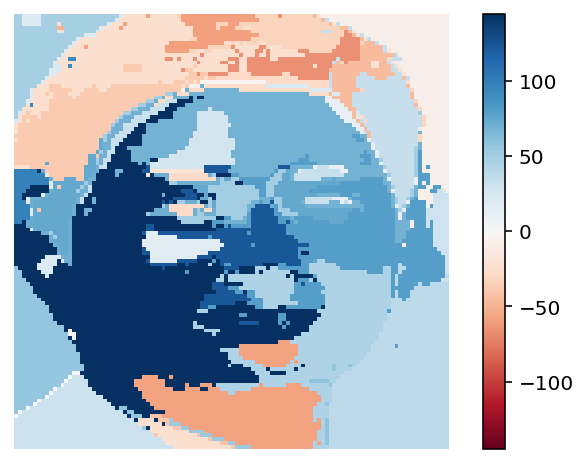

In [82]:
plot_face_heatmap(arcface, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 391.7573583435102
Prediction_local [897.2158431]
Right: 918.8775
Intercept 584.9226539128416
Prediction_local [1141.63578913]
Right: 1159.709


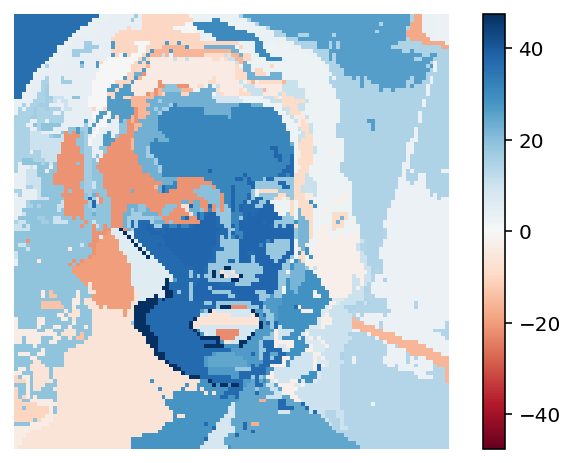

In [83]:
plot_face_heatmap(arcface, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 374.34799973289955
Prediction_local [1099.59524257]
Right: 1112.9669
Intercept 671.2828511737076
Prediction_local [1466.02871722]
Right: 1475.9894


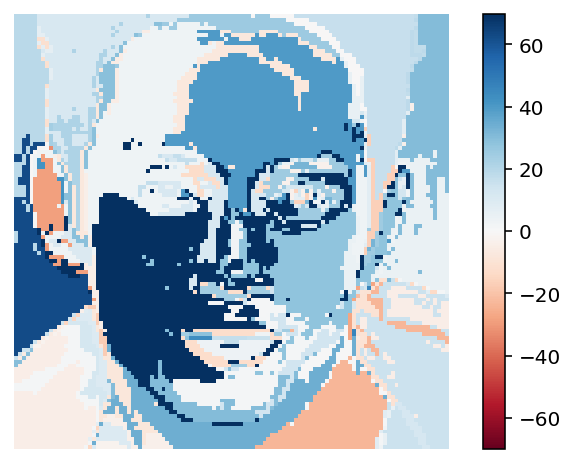

In [84]:
plot_face_heatmap(arcface, indian_img)

**Results**:
* Caucasian image has important forehead on all models
* ArcFace does not detect same face patterns for African as others